# 感知机(Perceptron)

## 定义

$$y = f(x) = sign(\omega \cdot x + b), $$

$$sign(x) = \left\{ \begin{array}{rcl} +1,& x\geq0 \\ -1, & x<0 \end{array} \right.$$

其中 $ \omega \in \mathcal{R^n}, \ b \in \mathcal{R}, x \in \mathcal{X}, y \in \mathcal{Y} $

$ \mathcal{X} \subseteq \mathcal{R^n} $ 是输入空间 

$ \mathcal{Y} = \{+1, -1\} $ 是输出空间

### 训练集
$$T = \{ (\textbf{x}_1, \textbf{y}_1), (\textbf{x}_2, \textbf{y}_2), \cdots, (\textbf{x}_n, \textbf{y}_n) \},$$ 

其中 $ \textbf x_i \in \mathcal{X}, \ y_i \in \mathcal{Y}, \ i = 1, 2, \cdots, N $

### 形式替换

$$y = f(x) = sign(\omega \cdot x + b) = sign(\omega^T \textbf{x}), $$

其中 $ \omega = [b, \omega_1, \omega_2, \cdots, \omega_n]^T, \textbf{x}_i = [+1, x_{i1}, x_{i2}, \cdots, x_{in}]^T $

相当于组合了$\omega$和b，便于推导，此时输入维度为n+1


## 学习算法

$$\omega(n+1) = \left\{ \begin{array}{rcl} \omega(n), & \hat{y}(n) = y(n) \\ \omega(n) + \eta(n)\textbf{x}(n), & \hat{y}(n) \neq y(n) & y(n)=1 \\ \omega(n) - \eta(n)\textbf{x}(n), & \hat{y}(n) \neq y(n) & y(n) =-1\end{array}\right.,$$

可得：

$$\omega(n+1) = \omega(n) + \eta y(n)\textbf{x}(n)$$

其中

 $\eta(n)$ 是学习率

 $\hat{y}(n) = f(\textbf{x}(n)) = sign(\omega \cdot \textbf{x}(n) + b)$ 是第 $n$ 个训练集样本的输出

 $y(n)$ 是第 $n$ 个训练集样本的标签

 $\textbf{x}(n)$ 是第 $n$ 个训练集样本的输入

 ## 收敛性

 ### Novikoff定理

 设训练数据集$T=\{ (x_1, y_1), (x_2, y_2), \cdots, (x_n, y_n) \}$线性可分，则有如下结论

* 存在满足$|| \omega_{opt} || = 1$的超平面$\omega_{opt} \cdot x = 0$将训练集完全正确分离；且存在$\gamma>0$，对所有的$i=1, 2, \cdots, n$有：
$$y_i(\omega_{opt} \cdot x_{i}) \geq \gamma$$

* 令$R = \max\limits_{1\leq i \leq n}||x_{i}||$，则训练集上误分类次数$k$满足下式

$$k \leq (\frac{R}{\gamma})^2$$

证明从略，见李航《统计学习方法》P42

## 对偶形式

对于感知机的参数更新有如下形式

$$\omega \leftarrow \omega + \eta y_i \textbf{x}_i$$

$$b \leftarrow b + \eta y_i$$

其中$(\textbf{x}_i, y_i)$为第i个误分类点，若假设第i个误分类点在训练中一共被误分类了$n_i$次，则可以得到在经过n次参数更新后，学到的$\omega$和$b$可以表示为：

$$\omega = \omega_0 + \sum_{i=1}^n \alpha_i y_i \textbf{x}_i$$

$$b = b_0 + \sum_{i=1}^n \alpha_i y_i$$

$$\alpha_i = n_i \eta$$


由此建立感知机模型的对偶形式：
$$f(x) = sign(\sum_{j=1}^n \alpha_j y_j \textbf{x}_j \cdot \textbf{x})$$

$$\textbf{x}_j = [+1, x_{j1}, x_{j2}, \cdots, x_{jn}]^T$$

其中训练实例仅以内积的形式出现，因此可以提前计算，然后直接调用

定义Gram矩阵：
$$\textbf{G} = [x_i \cdot x_j]_{N \times N}$$

## 案例

### 基本逻辑运算（二维）
* and
* or
* Not
* xoR

#### 基本逻辑运算真值表
|$x_1$|$x_2$|and|or|Not($x_1$)|Not($x_2$)|xoR|
|--|--|--|--|--|--|--|
|0|0|-1|-1|1|1|-1|
|0|1|-1|1|1|-1|1|
|1|0|-1|1|-1|1|1|
|1|1|1|1|-1|-1|-1|

### 其他测试数据

主要基于sklearn生成

### 代码

下述的训练流程中采用随机送入样本的形式

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import imageio
import os
import random
from sklearn.datasets import make_blobs, make_moons

# seed
random.seed(1024)
np.random.seed(1024)

In [2]:
# 定义模型class
class Perceptron(object):

    def __init__(self, input_dim=2, output_dim=1, eta=1) -> None:
        super().__init__()

        # 输入维度
        self.input_dim = input_dim
        # 输出维度
        self.output_dim = output_dim
        # 学习率
        self.eta = eta

        # w，这里使用组合模式下的，即将b放入w，默认为0
        self.omega_list = np.zeros(input_dim+1)

        # 绘制记录
        self.draw_count = 0
    
    def train(self, input_x, output_y):
        """
        训练主函数
        """
        output_y = np.array(output_y)
        # 扩展输入维度, 和公式推导不同，这里将1置于末尾
        input_x.append(1)
        input_x = np.array(input_x)

        # 获取预测
        pred_y = np.sign(np.dot(input_x, self.omega_list))

        # 判断是否更新参数
        if pred_y * output_y <= 0:
            # 预测输出与实际输出符号不一致，进行更新
            self.omega_list = self.omega_list + self.eta * output_y * input_x
            return True
        else:
            return False
    
    def test(self, input_x_list, output_y_list):
        """
        判断是否训练完成
        """
        input_x_list = np.array(input_x_list)
        bias_x = np.ones((len(output_y_list)))
        input_x_list = [input_x_list[:, 0], input_x_list[:, 1], list(bias_x)]

        pred_y = np.sign(np.dot(self.omega_list, input_x_list))

        if np.sum(pred_y == np.array(output_y_list)) == len(output_y_list):
            return True
        else:
            return False
    
    def draw(self, input_x_list, output_y_list):
        """
        绘制函数
        """
        input_x_list = np.array(input_x_list)
        input_dim = np.shape(input_x_list)[1]
        if np.shape(input_x_list)[1] != 2:
            raise ValueError("仅能绘制输入维度为2的结果，但是接受到的维度为{}".format(input_dim))
        
        # 绘制所有训练数据
        plt.cla()
        plt.scatter(input_x_list[:, 0], input_x_list[:, 1], c=output_y_list)

        # 绘制学到的分离面

        # x_1_point_list = np.lnspace(input_x_1_range[0]-0.1*x_1_len, input_x_1_range[1]+0.1*x_1_len)
        # 绘制直线
        # 分离平面 w x + b = 0
        # 对于二维输入,有
        # w1 x1 + w2 x2 + b = 0
        # x2 = (-b-w1 x1)/w2
        
        # 设置标记点
        input_x_1_range = [np.min(input_x_list[:, 0]), np.max(input_x_list[:, 0])]
        input_x_2_range = [np.min(input_x_list[:, 1]), np.max(input_x_list[:, 1])]
        # 区间长度
        x_1_len = input_x_1_range[1] - input_x_1_range[0]
        x_2_len = input_x_2_range[1] - input_x_2_range[0]

        point_x_1_list = np.linspace(input_x_1_range[0]-0.1*x_1_len, input_x_1_range[1]+0.1*x_1_len, 100)

        # 判断是否是y=c或者x=c
        if self.omega_list[0] == 0 and self.omega_list[1] == 0:
            # 均为0，为单点
            point_x_1_list = np.zeros_like(point_x_1_list)
            point_x_2_list = np.zeros_like(point_x_1_list)
        else:
            if self.omega_list[1] == 0:
                # x1 = c
                point_x_1_list = -np.ones_like(point_x_1_list) * self.omega_list[-1]/self.omega_list[0]
                point_x_2_list = np.linspace(input_x_2_range[0]-0.1*x_1_len, input_x_2_range[1]+0.1*x_1_len, len(point_x_1_list))
            elif self.omega_list[0] == 0:
                # x2 = c
                point_x_2_list = -np.ones_like(point_x_1_list) * self.omega_list[-1]/self.omega_list[1]
            else:
                point_x_2_list = -(self.omega_list[-1] + self.omega_list[0] * point_x_1_list)/self.omega_list[1]

        plt.plot(point_x_1_list, point_x_2_list, "-r")

        plt.xlim(input_x_1_range[0]-0.2*x_1_len, input_x_1_range[1]+0.2*x_1_len)
        plt.ylim(input_x_2_range[0]-0.2*x_2_len, input_x_2_range[1]+0.2*x_2_len)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("weight: {}".format(self.omega_list))

        plt.savefig("./images/temp/{}.png".format(self.draw_count), dpi=150)
        self.draw_count += 1
    
    def create_gif(self, output_name):
        """
        生成gif
        """
        with imageio.get_writer("./images/{}.gif".format(output_name), mode="I", fps=2) as Writer:
            for ind in range(self.draw_count):
                image = imageio.imread("./images/temp/{}.png".format(ind))
                os.remove("./images/temp/{}.png".format(ind))
                Writer.append_data(image)
    
    def clear_weight(self):
        self.omega_list *= 0

In [3]:
# 数据

class DataCreator(object):

    def __init__(self) -> None:
        super().__init__()

    @staticmethod
    def get_and_data():
        x_list = [[0, 0], [0, 1], [1, 0], [1, 1]]
        y_list = [-1, -1, -1, 1]
        return x_list, y_list

    @staticmethod
    def get_or_data():
        x_list = [[0, 0], [0, 1], [1, 0], [1, 1]]
        y_list = [-1, 1, 1, 1]
        return x_list, y_list

    @staticmethod
    def get_nor_data(nor_index):
        x_list = [[0, 0], [0, 1], [1, 0], [1, 1]]
        y_list = list()
        for i in range(len(x_list)):
            if x_list[i][nor_index]:
                y_list.append(-1)
            else:
                y_list.append(1)
        
        return x_list, y_list

    @staticmethod
    def get_xor_data():
        x_list = [[0, 0], [0, 1], [1, 0], [1, 1]]
        y_list = [-1, 1, 1, -1]
        return x_list, y_list

    @staticmethod
    def get_moon_data(sample_num, noise=0.05):
        x_list, y_list = make_moons(sample_num, noise=noise, random_state=1024)
        y_list = y_list * 2 - 1
        return x_list, y_list

    @staticmethod
    def get_blob_data(sample_num, std=0.6):
        x_list, y_list = make_blobs(n_samples=sample_num, centers=2, 
                                    cluster_std=0.6, random_state=1024)
        y_list = y_list * 2 - 1
        return x_list, y_list

In [4]:
# 正式测试
%matplotlib inline

### and逻辑

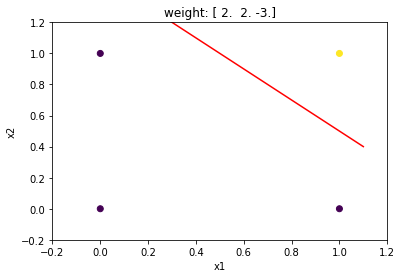

In [5]:
# and

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 1e3

# 获取训练数据
train_x, train_y = data_loader.get_and_data()
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, 3)
    input_x = train_x[sample_ind].copy()
    output_y = train_y[sample_ind]
    # display.clear_output(wait=True)
    # plt.pause(0.1)

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("add_perceptron")
plt.show()

### 训练动图

![add](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/add_perceptron.gif "segment")

### or逻辑

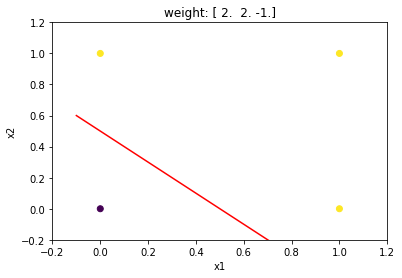

In [6]:
# or

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 1e3

# 获取训练数据
train_x, train_y = data_loader.get_or_data()
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, 3)
    input_x = train_x[sample_ind].copy()
    output_y = train_y[sample_ind]
    # display.clear_output(wait=True)
    # plt.pause(0.1)

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("or_perceptron")
plt.show()

### 结果展示

![](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/or_perceptron.gif "segment")

### Nor(x1)

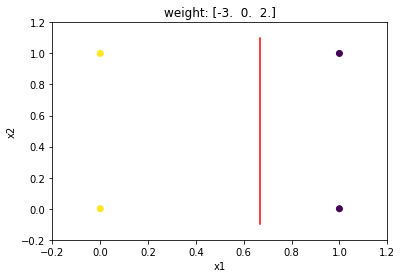

In [7]:
# Nor(x1)

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 1e3

# 获取训练数据
train_x, train_y = data_loader.get_nor_data(0)
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, 3)
    input_x = train_x[sample_ind].copy()
    output_y = train_y[sample_ind]
    # display.clear_output(wait=True)
    # plt.pause(0.1)

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("nor_x1_perceptron")
plt.show()

### 结果展示

![](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/nor_x1_perceptron.gif "segment")

### Nor(x2)

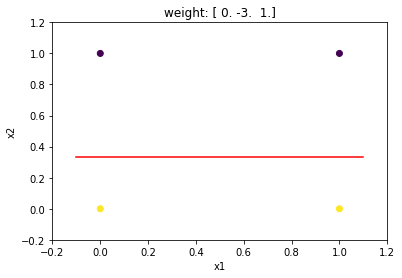

In [8]:
# Nor(x2)

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 1e3

# 获取训练数据
train_x, train_y = data_loader.get_nor_data(1)
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, 3)
    input_x = train_x[sample_ind].copy()
    output_y = train_y[sample_ind]
    # display.clear_output(wait=True)
    # plt.pause(0.1)

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("nor_x2_perceptron")
plt.show()

### 结果展示

![](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/nor_x2_perceptron.gif "segment")

### xoR

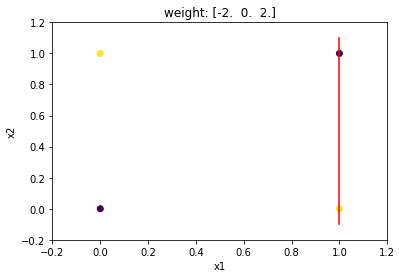

In [10]:
# xoR

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 100

# 获取训练数据
train_x, train_y = data_loader.get_xor_data()
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, 3)
    input_x = train_x[sample_ind].copy()
    output_y = train_y[sample_ind]

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("xor_perceptron")
plt.show()

### 结果展示

![xor](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/xor_perceptron.gif "segment")

### 线性可分的样本簇

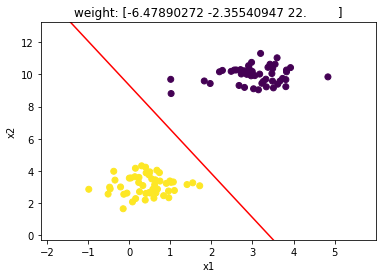

In [11]:
# blobs

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 1e4

# 获取训练数据
train_x, train_y = data_loader.get_blob_data(sample_num=100)
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, len(train_y)-1)
    input_x = list(train_x[sample_ind].copy())
    output_y = train_y[sample_ind]

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("blobs_perceptron")
plt.show()

### 结果展示

![blobs](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/blobs_perceptron.gif "segment")

### 线性不可分的样本簇

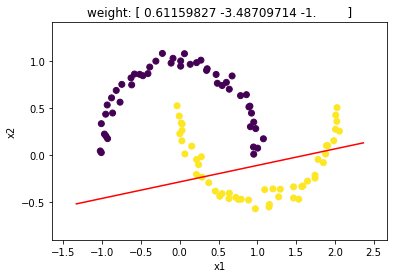

In [12]:
# moons

# 模型
preceptron_model = Perceptron(eta=1)
# 数据生成器
data_loader = DataCreator()
# 最大训练次数
max_loop = 100

# 获取训练数据
train_x, train_y = data_loader.get_moon_data(sample_num=100)
train_num = len(train_x)
# 循环次数
train_loop = 0

while True:
    sample_ind = random.randint(0, len(train_y)-1)
    input_x = list(train_x[sample_ind].copy())
    output_y = train_y[sample_ind]

    if preceptron_model.train(input_x, output_y):
        preceptron_model.draw(train_x, train_y)
    train_loop += 1

    # 测试是否分类完成
    if preceptron_model.test(train_x, train_y) or train_loop == max_loop:
        break

# plt.show()
preceptron_model.draw(train_x, train_y)
preceptron_model.create_gif("moons_perceptron")
plt.show()

### 结果展示

![moons](https://raw.githubusercontent.com/koolo233/NeuralNetworks/main/images/moons_perceptron.gif "segment")